# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add DBS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/DiffusionBarriers/DBS")

Wall time: 0 ns


# Overview


In the following notebook we visualize diffusion extremizers using the Diffusion Barrier Sensitivity (DBS) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Diffusion Barrier Sensitivity (DBS):

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
    
    * Compute time-averaged diffusion Cauchy Green strain tensor as: 
    
    \begin{equation} \mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N}[\mathbf{C}_D]_{t_0}^{t_N} dt = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N} det[\mathbf{D}(\mathbf{F}_{t_0}^t(\mathbf{x}_0), t)][\mathbf{T}_{t_0}^t(\mathbf{x}_0)]^{-1} dt, \end{equation} where $ \mathbf{T}_{t_0}^t(\mathbf{x}_0) = [\mathbf{\nabla_0 F_{t_0}^t}(\mathbf{x}_0)]^{-1}\mathbf{D}(\mathbf{F}_{t_0}^t(\mathbf{x}_0), t)\mathbf{\nabla_0 F_{t_0}^t}(\mathbf{x}_0)]^{-T} $ 
    
    * Compute DBS as:
    
    \begin{equation}
    \mathrm{DBS}_{t_0}^{t_N}(\mathbf{x}_0) = \mathrm{trace}(\mathbf{\overline{C}_D}_{t_0}^{t_N}(\mathbf{x}_0)).
    \end{equation}

# Import Data

We start by importing the AVISO-data from the file 'AVISO.mat' stored in the folder 'data'.

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 117 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# number of cores to be used for parallel computing
Ncores = 4

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

Wall time: 997 µs


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

# NOTE: For backward computation set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # len(time) = N

# length of time interval (in days)
lenT = abs(tN-t0)

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 996 µs


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 193 ms


# Diffusion Barrier Sensitivity (DBS)

Next, we compute the DBS over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{100}, \dfrac{1}{5}] $. From the gradient of the flow map and the given diffusivity tensor, we can then compute the time-averaged, diffusive structure-weighted version of the classic right Cauchy–Green strain tensor. The iteration over the meshgrid is parallelized.

In [6]:
%%time
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to integrate trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute Diffusion Barrier Sensitivity
from ipynb.fs.defs.DBS import _DBS

# Import function to compute Diffusion Cauchy Green strain tensor
from ipynb.fs.defs.DiffusionCauchyGreen import DiffusionCauchyGreen

# Import RegularGridInterpolator
from scipy.interpolate import RegularGridInterpolator

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

# number of diffusive Cauchy Green strain tensor used for averaging
# if n_averaging = 10, then only every 10th data point is used for computing the temporal average of the diffusive CG-tensor
n_averaging = 10 # set to 1 if you want to use all values

# Components of diffusivity tensor D11, D12, D22 over spatial meshgrid and time have shape (Ny, Nx, N)
# , where Ny/Nx are the spatial resolution in the lat/long coordinates
# and N the time-resolution of the data
D11_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)
D12_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)
D22_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1])) # (Ny, Nx, N)

# Diffusivity Tensor (we set it to be constant in space and time).
D11 = 1
D12 = 0
D22 = 1
D11_field[:,:,:] = D11
D12_field[:,:,:] = D12
D22_field[:,:,:] = D22

# Interpolate D11_field/D12_field/D22_field over spatial and temporal domain
Interpolant_D11 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D11_field)
Interpolant_D12 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D12_field)
Interpolant_D22 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D22_field)

def parallel_DBS(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])

    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, dt_data)[0] # shape (N, 2, Nx*Ny)
    
    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, dt_data, aux_grid) # shape (N, 2, 2, Nx*Ny)
    
    # compute CG
    Cd_avg = gradFmap[0,:,:,:].copy()*np.nan # shape (N, 2, 2, Nx*Ny)
    
    DBS_parallel = []
    
    for i in range(gradFmap.shape[3]):
        Cd_avg[:,:,i] = DiffusionCauchyGreen(Interpolant_D11, Interpolant_D12, Interpolant_D22, time, Fmap[:,:,i], gradFmap[:,:,:,i], lenT, n_averaging) # shape (2, 2, Nx*Ny)
        
        DBS_parallel.append(_DBS(Cd_avg[:,:,i]))
    
    return DBS_parallel
    
# Compute DBS with parallel computing
results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_DBS)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract DBS field from results of parallel computing
DBS = results[0]

for res in results[1:]:
    DBS = np.append(DBS, res)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
DBS = DBS.reshape((X_domain.shape[0], X_domain.shape[1]))

Wall time: 2min 54s


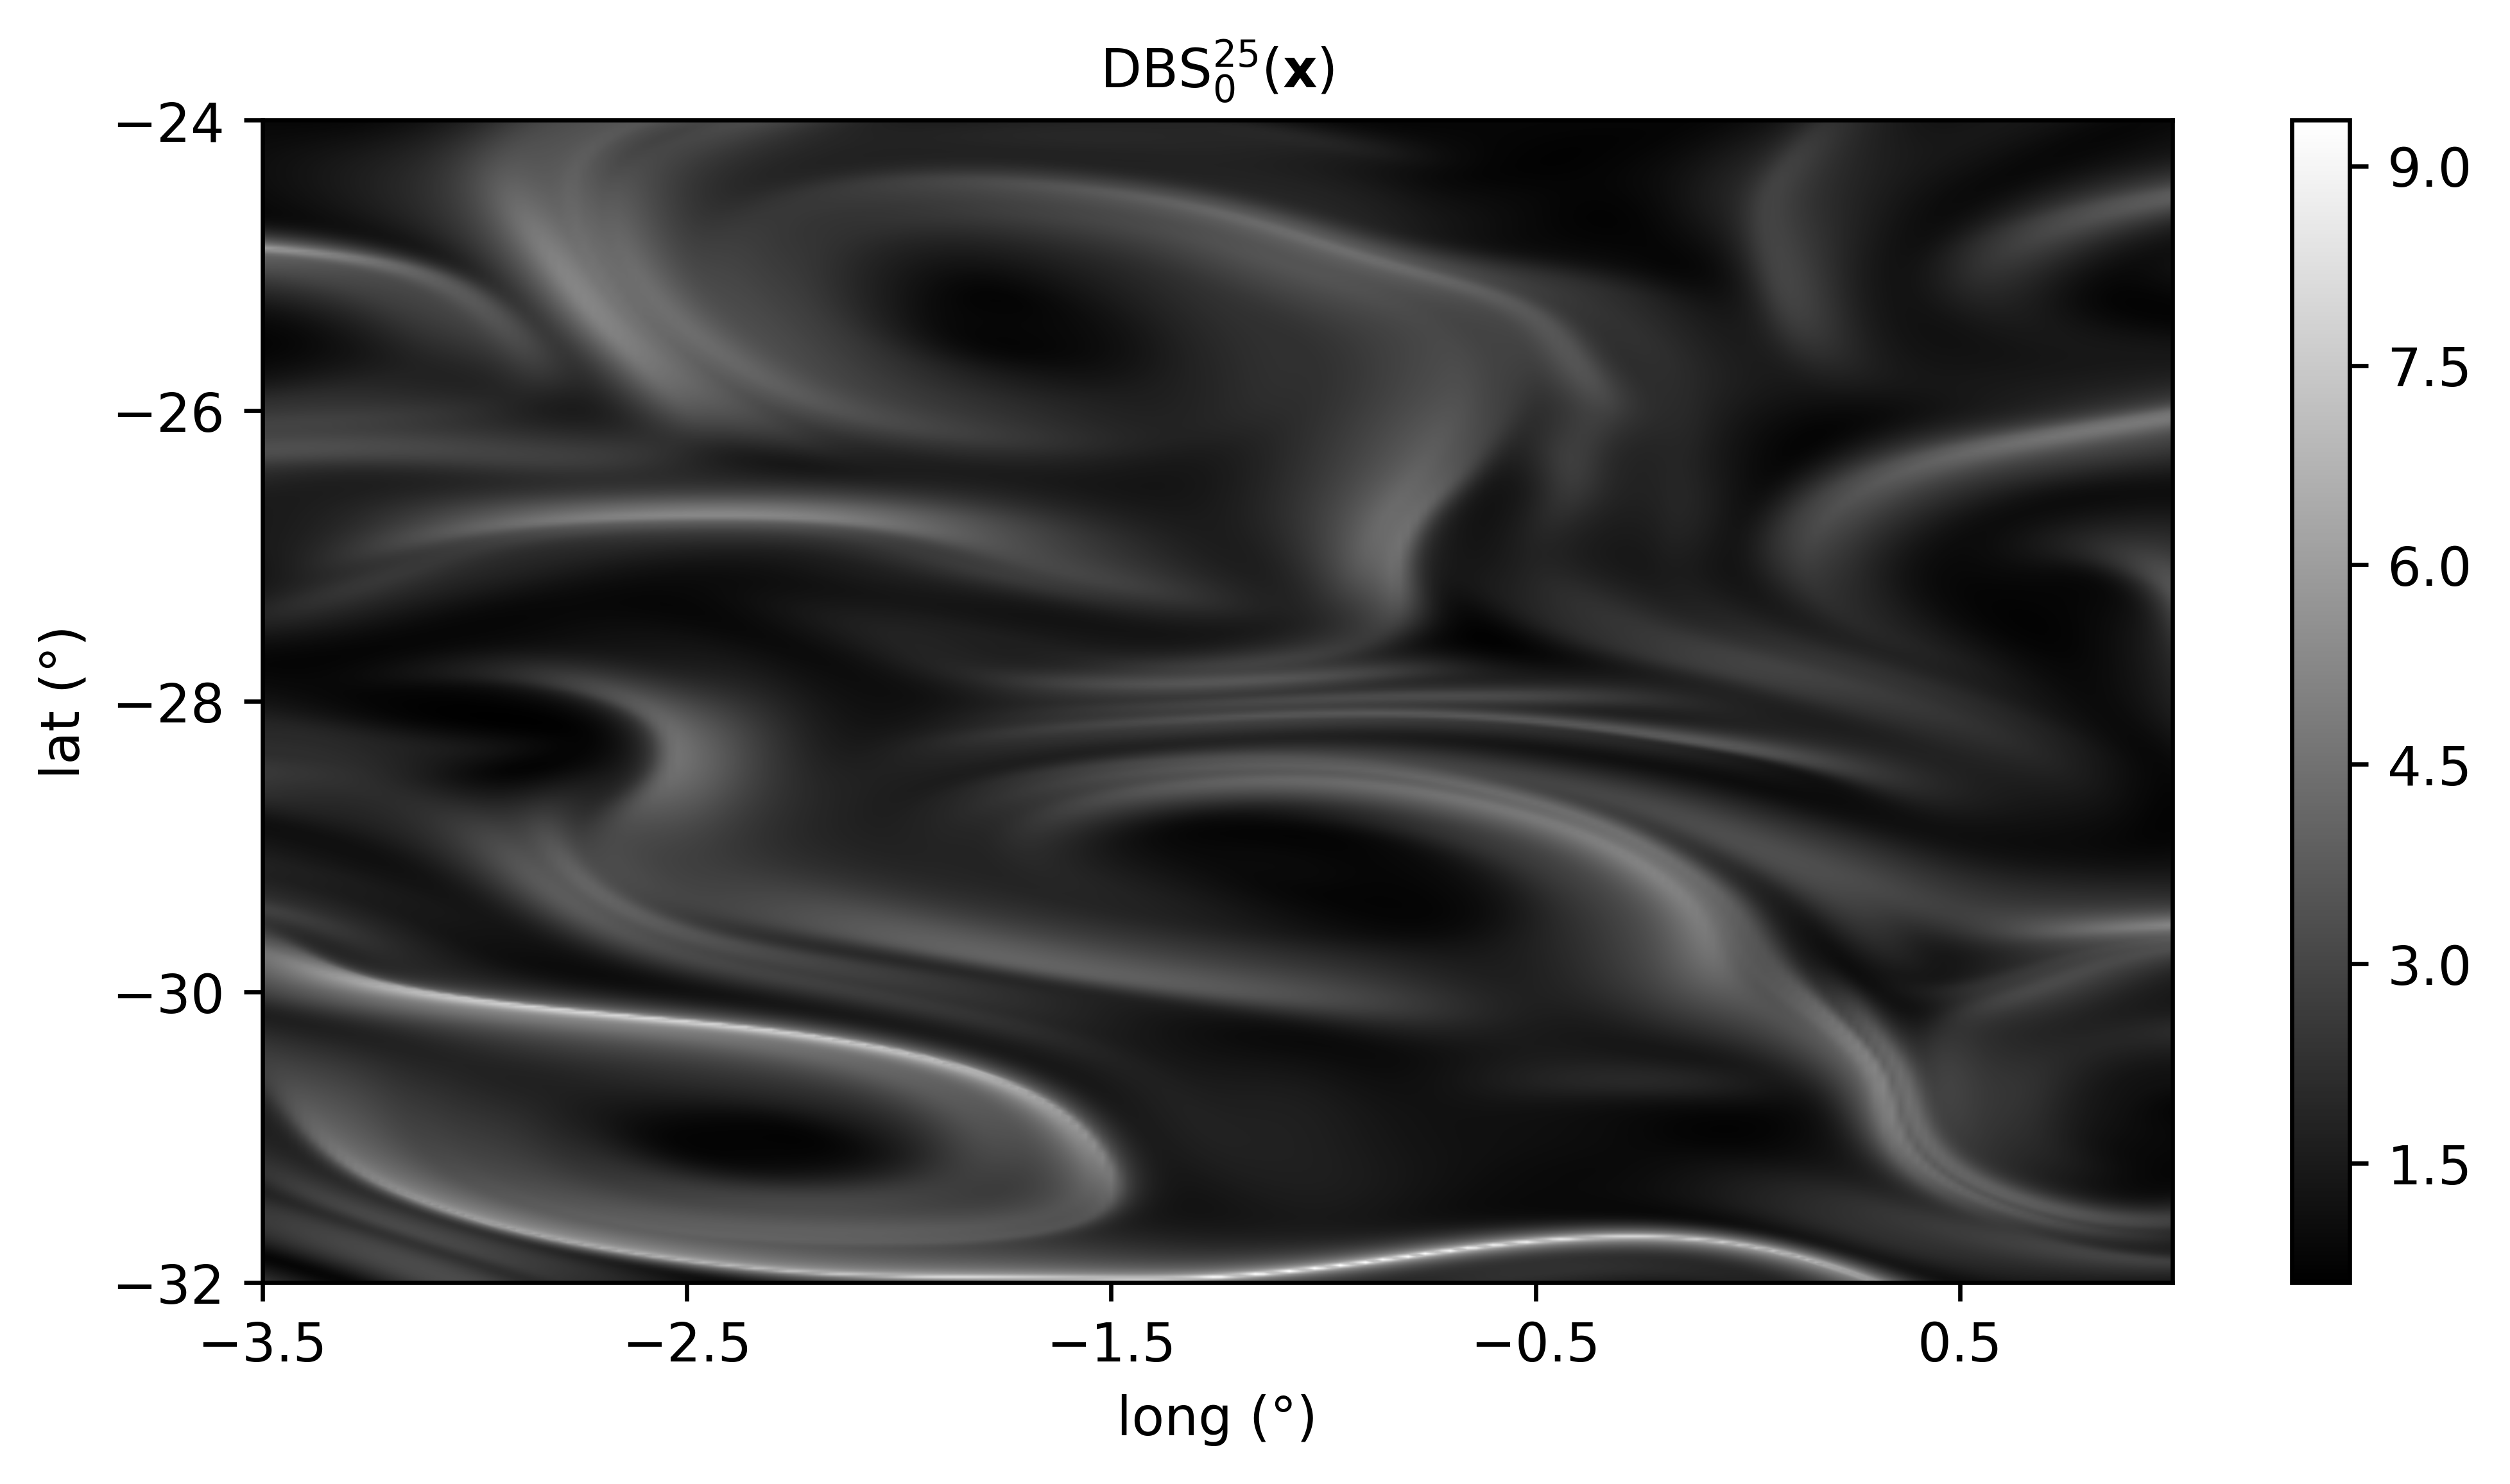

In [7]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of DBS over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.log(np.ma.masked_invalid(DBS)), cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 12, 9))

# Title
ax.set_title(r'$ \mathrm{DBS}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

By construction, features of the $ \mathrm{DBS} $ are analogous to those of the finite-time Lyapunov exponents
(FTLEs) in purely advective transport. $ \mathrm{DBS} $ is a predictive visual diagnostic which qualitatively locates diffusion extremizers. Ridges of $ \mathrm{DBS} $, indicate the most prevailing diffusion barriers, whereas trenches of the $ \mathrm{DBS} $ mark the least prevailing diffusion barriers. An analogous statement holds for diffusion
enhancers computed from the backward $ \mathrm{DBS} $. Ridges of $ \mathrm{DBS} $ computed in backward time indicate the most prominent diffusion enhancers.

# References

[1] Haller, G., Karrasch, D., & Kogelbauer, F. (2018). Material barriers to diffusive and stochastic transport. Proceedings of the National Academy of Sciences, 115(37), 9074-9079.